## Simple MultiAI agent Architecture

In [1]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search  import TavilySearchResults
from langgraph.graph import StateGraph,END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver


In [4]:
# Define the state for the agent
class AgentState(MessagesState):
    next_agent:str #which agent to call next

In [5]:
# Creating  simple tools
@tool
def search_web(query:str)-> str:
    """Search the web for information."""
    # using TavilySearchResults to perform a web search
    search=TavilySearchResults(max_results=5)
    results=search.invoke(query)
    return str(results)

@tool
def write_summary(content:str)-> str:
    """write a summary of the provided content."""
    #Simple summary generation
    summary=f'summary of findings:\n \n {content[:500]}...'
    return summary


In [6]:
from langchain.chat_models import init_chat_model
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    # other params...
)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000019570045710>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000195701987D0>, model_name='deepseek-r1-distill-llama-70b', temperature=1e-08, reasoning_format='parsed', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
# Define agent Functions

def researcher_agent(state:AgentState):
    """Researcher agent the searches the web for information."""

    messages=state['messages']

    #add the system for context 
    system_msg=SystemMessage(content= "You are a research assistant. Use the search_web tool to find information on the topic which user request.")
    
    # Call the LLM with the messages
    researcher_llm=llm.bind_tools([search_web])
    response=researcher_llm.invoke([system_msg]+ messages)

    # Return the response and route to writer agent

    return{
        "messages":[response],
        "next_agent":"writer"
    }

In [8]:
def writer_agent(state:AgentState):
    """writer agent that creates a summary of the findings."""
    messages=state['messages']

    # Add system message
    system_msg=SystemMessage(content="You are a technical writer. Review the converstation and create a clear, concise summary of the findings")

    # Simple completion without tools
    response=llm.invoke([system_msg]+ messages)

    return {
        "messages":[response],
        "next_agent":'END'  # End the workflow after writing
    }


In [9]:
# Tool executor node

def execute_tools(state:AgentState):
    """Execute any pending tool calls."""
    messages=state['messages']
    last_message=messages[-1]


    # check if there are any tools calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
       #create tool node and execute the tool
       tool_node=ToolNode([search_web, write_summary])
       response=tool_node.invoke(state)
       return response
    
    # No tools to execute
    return state
 

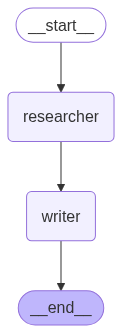

In [10]:
# Build the graph
workflow = StateGraph(MessagesState)

#Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer",writer_agent)

# define the flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher",'writer')
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow



In [11]:
final_workflow.invoke({"messages":"Research about the use case of MIRV Technology in modern warfare."})

{'messages': [HumanMessage(content='Research about the use case of MIRV Technology in modern warfare.', additional_kwargs={}, response_metadata={}, id='1cff652f-0ad0-4ae3-87a3-dffa78d7d3ea'),
  AIMessage(content="To address the use case of MIRV (Multiple Independently Targetable Reentry Vehicle) technology in modern warfare, we must consider its strategic, technical, and geopolitical implications:\n\n1. **Strategic Deterrence**: MIRV technology allows a single missile to carry multiple warheads, each targeting different locations. This enhances the deterrent effect by increasing the potential damage an adversary might suffer, thus discouraging an attack.\n\n2. **Overwhelming Missile Defenses**: By deploying multiple warheads from one missile, MIRV technology can saturate and overwhelm missile defense systems, making it harder for defenders to intercept all incoming threats.\n\n3. **Balance of Power**: Countries like the United States, Russia, and China use MIRV technology to maintain a

In [12]:
from pprint import pprint
pprint(final_workflow.invoke({"messages":"Research about the use case of MIRV Technology in modern warfare."}))

{'messages': [HumanMessage(content='Research about the use case of MIRV Technology in modern warfare.', additional_kwargs={}, response_metadata={}, id='2cead5a1-3c22-4a10-b808-4db13b32f883'),
              AIMessage(content="To address the use case of MIRV (Multiple Independently Targetable Reentry Vehicle) Technology in modern warfare, we must consider several key aspects:\n\n1. **Strategic Advantages**: MIRV technology allows a single missile to deliver multiple warheads, each targeting different locations. This increases the efficiency and lethality of a missile strike, making it harder for defense systems to intercept all incoming warheads.\n\n2. **Countries Utilizing MIRV**: The United States, Russia, and China are prominent users of MIRV technology. Each employs it within their strategic doctrines to maintain deterrence and ensure the effectiveness of their nuclear forces against evolving missile defense systems.\n\n3. **Impact on Global Security**: MIRV technology complicates ar

## Supervised MultiAI Agent Architecture

In [13]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [14]:
## State Defination

class SupervisorState(MessagesState):
    "State for the supervisor multi agent system."
    current_agent: str="" # The agent currently being supervised
    task_assignments:Dict[str,List[str]]={} # Task assignments for each agent
    agent_outputs:Dict[str,Any]={}
    workflow_stage:str="initial"  # The current stage of the workflow
    iteration_count:int=0  # Number of iterations completed
    max_iterations: int=10
    final_output: str=""

In [15]:
# Next agent state
class SupervisorState(MessagesState):
    "State for the supervisor multi agent system."
    next_agent: str=""  # The agent currently being supervised
    research_data: str = ""  # Data collected by the researcher
    analysis:str=""
    final_report:str=""
    task_complete:bool=False  # Flag to indicate if the task is complete
    current_task:str=""
    

In [16]:
## Supervisor with groq LLM

def create_supervisor_chain():
    "Creates a supervisor decision-making chain."

    supervisor_prompt=ChatPromptTemplate.from_messages([
        ("system",""" you are a supervisor managing a team of agents:
         
1. Researcher: Gathers information and data.
2. Analyst: Analyzes the data and provides insights.
3. Writer: Creates a final report and summaries based on the analysis.

Based on current state and conversation, decide which agent should work next.
If the task is complete, respond with "done".

Current state:
- Has research data:{has_research}
- Has analysis:{has_analysis}
- Has final report:{has_report}

Respond with only the agent name (Researcher, Analyst, Writer) or "done" if the task is complete.
"""),

         ("human","{task}")
    ])
    
    return supervisor_prompt | llm


In [17]:
# # Supervisor Agent.

# def supervisor_agent(state:SupervisorState)->  Dict:

#     """Supervisor_agent decides next agent using LLM."""

#     messages=state['messages']
#     task=messages[-1].content if messages else "No task"

#     # Check if the task is complete
#     has_research = bool(state.get("research_data",""))
#     has_analysis = bool(state.get("analysis",""))
#     has_report = bool(state.get("final_report",""))

#     # Get LLM Decision
#     chain=create_supervisor_chain()
#     decision=chain.invoke({
#         "task": task,
#         "has_research": has_research,
#         "has_analysis": has_analysis,
#         "has_report": has_report
#     })

#     # Parse the decision
#     decision_text= decision.content.strip().lower()
#     print(f"Supervisor Decision: {decision_text}")

#     # Determine next agent based on decision
#     if "done" in decision_text or has_report:
#         next_agent = "END"
#         supervisor_msg='All the tasks are completed. Great job team!'

#     elif "Researcher" in decision_text or not has_research:
#         next_agent = "Researcher"
#         supervisor_msg="Supervisor: Researcher, please gather information on the topic. Assigning to Researcher agent...."

#     elif "Analyst" in decision_text or (has_research and not has_analysis):
#         next_agent = "Analyst"
#         supervisor_msg="Supervisor: Analyst, please analyze the research data. Assigning to Analyst agent...."

#     elif "Writer" in decision_text or (has_analysis and not has_report):
#         next_agent = "Writer"
#         supervisor_msg="Supervisor: Writer, please create a final report based on the analysis. Assigning to Writer agent...."

#     else:
#         next_agent = "end"
#         supervisor_msg="Supervisor: Task seems completed."


#     return{
#         "messages":[AIMessage(content=supervisor_msg)],
#         "next_agent": next_agent,
#         "current_task": task,
#     }

from langchain_core.messages import AIMessage

def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor_agent decides next agent using LLM."""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"

    # Determine current stage
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))

    # Get decision from LLM
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })

    decision_text = decision.content.strip().lower()
    print(f"Supervisor Decision: {decision_text}")

    # Tighten up decision logic
    if decision_text in ["done", "end"] or (has_research and has_analysis and has_report):
        next_agent = "END"
        supervisor_msg = "Supervisor: All tasks are completed. Great job team!"

    elif decision_text == "researcher" or not has_research:
        next_agent = "researcher"
        supervisor_msg = "Supervisor: Researcher, please gather information on the topic."

    elif decision_text == "analyst" or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "Supervisor: Analyst, please analyze the research data."

    elif decision_text == "writer" or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "Supervisor: Writer, please prepare the final report."

    else:
        next_agent = "supervisor"
        supervisor_msg = "Supervisor: Re-evaluating... no valid task decision."

    return {
        "messages": messages + [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }



In [18]:
# Agent 1 Researcher Agent

def researcher_agent(state:SupervisorState) -> Dict:
    """ Researcher agent uses Groq to gather information."""

    task=state.get("current_task", "research topic")

    # create a research prompt
    research_prompt=f"""As a Expert Researcher, your task is to gather information on the topic: {task}.

    Include:
    1. Key facts and Background information
    2. Current trends and developments
    3. Important statistics or data points
    4. Notable examples or case studies.

    Be concise but thorough in your research."""

    # Get research from LLM
    research_response= llm.invoke([HumanMessage(content=research_prompt)])
    research_data=research_response.content

    # Create agent message
    agent_message=f" Researcher: I have completed the research on {task}. Here are my findings:\n\n{research_data}"

    return {
        "messages":state['messages']+[AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent":"supervisor",  # Route to supervisor for next steps
    }

In [19]:
# Agent 2 Analyst Agent

def analyst_agent(state:SupervisorState) -> Dict:
    """Analyst agent analyzes the research data."""

    research_data = state.get("research_data","")
    task=state.get("current_task","")

    #Create analysis prompt
    analyst_agent_prompt=f""" As a Expert Analyst, analyze the research data and provide insights.

    Research data: {research_data}

    provide:
    1. Key insights and patterns
    2. Stratergic implications
    3. Risk and opportunities
    4. Recommendations
    
    focus on actionable insights related to: {task}"""

    # Get analysis from LLM
    analysis_response=llm.invoke([HumanMessage(content=analyst_agent_prompt)])
    analysis= analysis_response.content

    # create agent message
    agent_message=f'Analyst: I have completed the analysis.\n\n insights:\n{analysis[:400]}...'

    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }




In [20]:
# Agent 3: Writer Agent

from langchain_core.messages import HumanMessage, AIMessage
from datetime import datetime

def writer_agent(state: SupervisorState) -> Dict:
    """Writer agent that creates a final executive report based on research and analysis."""

    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "the task")

    # Build the writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}
Research findings: {research_data[:1000]}
Analysis: {analysis[:1000]}

Ensure the report is clear, concise, and well-structured with:
1. Executive Summary
2. Key Findings
3. Analysis and Insights
4. Conclusion
5. Recommendations

Keep it professional and concise.
"""

    #  Call LLM to generate report
    response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = response.content

    # Format final report
    final_report = f"""
FINAL REPORT
{'='*50}
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI system powered by Groq LLM.
"""

    return {
        "final_report": final_report,
        "messages": state["messages"] + [AIMessage(content="Writer: Report completed!\n\n" + final_report)],
        "next_agent": "supervisor",
        "task_complete": True
    }


In [21]:
# Router function

def router(state:SupervisorState)-> Literal['supervisor', 'researcher', 'analyst', 'writer', '__end__']:
    """Router function to determine next agent based on state."""
    
    next_agent=state.get('next_agent','supervisor')

    if next_agent.upper() == 'END' or state.get('task_complete', False):
        return 'END'  # End the workflow if task is complete
    
    if next_agent in ['supervisor','researcher','analyst','writer']:
        return next_agent
    
    return "supervisor"  # Default to supervisor if no valid next agent is found

In [22]:
# Create workflow 
workflow= StateGraph(SupervisorState)

# Add nodes
workflow.add_node('supervisor', supervisor_agent)
workflow.add_node('researcher', researcher_agent)
workflow.add_node('analyst', analyst_agent) 
workflow.add_node('writer', writer_agent)

# set entry point

workflow.set_entry_point('supervisor')

# Add routing
for node in ['supervisor', 'researcher', 'analyst', 'writer']:
    workflow.add_conditional_edges(
         node, 
         router,
         {
                "supervisor": "supervisor",
                "researcher": "researcher",
                "analyst": "analyst",
                "writer": "writer",
                "END": END
         }
                      
    )

graph= workflow.compile()


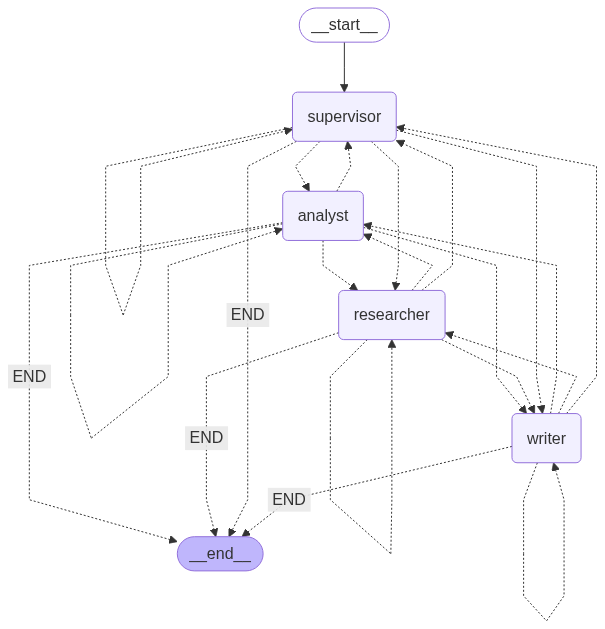

In [23]:
graph

In [24]:
graph.invoke({"messages": "Role of rice and wheat in diabetic patients"})

Supervisor Decision: to address the role of rice and wheat in diabetic patients, we need to consider several factors:

1. **glycemic index (gi):** 
   - white rice generally has a high gi, which can cause rapid blood sugar spikes. in contrast, whole wheat tends to have a lower gi, making it a more suitable option for diabetics.
   - specific types like basmati rice may have a lower gi compared to jasmine rice, and whole wheat products are preferable over refined ones.

2. **fiber content:**
   - whole wheat typically has higher fiber content than white rice, aiding in slower digestion and absorption, thus stabilizing blood sugar levels.
   - brown rice offers more fiber than white rice, making it a better choice for diabetics.

3. **portion control:**
   - even high gi foods can be manageable in small portions. balancing these carbs with protein and healthy fats can help moderate blood sugar spikes.

4. **preparation and additions:**
   - incorporating protein or healthy fats into meal

{'messages': [HumanMessage(content='Role of rice and wheat in diabetic patients', additional_kwargs={}, response_metadata={}, id='edc6db1a-9393-49fa-894b-063c64342faa'),
  AIMessage(content='Supervisor: Researcher, please gather information on the topic.', additional_kwargs={}, response_metadata={}, id='d86d4ff9-5da6-46af-b090-4a9cac1d8766'),
  AIMessage(content=' Researcher: I have completed the research on Role of rice and wheat in diabetic patients. Here are my findings:\n\nThe role of rice and wheat in the diet of diabetic patients is a complex issue that involves understanding their glycemic impact, nutritional content, and cultural significance. Here is a structured summary of the key points:\n\n1. **Glycemic Index (GI) and Impact on Blood Sugar:**\n   - **White Rice:** High GI (around 80), leading to rapid blood sugar spikes.\n   - **Brown Rice:** Lower GI (around 50), due to higher fiber content, making it a better choice for diabetics.\n   - **Whole Wheat:** Lower GI (around 3